In [170]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, filters, color
from typing import List, Tuple

# Load images and convert to grayscale
im1 = cv2.imread('exemples/photos 1 pièce/photo_piece1.jpeg')
im2 = cv2.imread('exemples/photos 1 pièce/photo_piece2.jpeg')
im3 = cv2.imread('exemples/photos 1 pièce/photo_piece3.jpeg')
im4 = cv2.imread('exemples/photos 1 pièce/photo_piece4.jpeg')
im5 = cv2.imread('exemples/photos 1 pièce/photo_piece5.jpeg')

# Grayscale versions for thresholding
im1g = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2g = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
im3g = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)
im4g = cv2.cvtColor(im4, cv2.COLOR_BGR2GRAY)
im5g = cv2.cvtColor(im5, cv2.COLOR_BGR2GRAY)

Lim=[im1,im2,im3,im4,im5]
Limg=[im1g,im2g,im3g,im4g,im5g]

## Plot functions

In [171]:

def plot_box_im(image: np.ndarray, boxes: List[Tuple[int, int, int, int]], title='') -> np.ndarray:
    """
    Draw bounding boxes on image for visualization.
    
    Args:
        image: Input image
        boxes: List of bounding boxes (x, y, width, height)
    
    Returns:
        Image with drawn boxes
    """
    result = image.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(result)
    plt.title(title)


import matplotlib.pyplot as plt
import cv2
import numpy as np
from typing import List, Tuple

def plot_Lbox_Lim(Lboxes: List[List[Tuple[int, int, int, int]]], Limg: List[np.ndarray], title=''):
    """
    Plot multiple images with bounding boxes arranged in two rows.
    
    Args:
        Lboxes: List of lists of bounding boxes for each image.
        Limg: List of images to display.
        title: Title for the entire plot.
    """
    # Determine the number of images and set up 2-row grid layout
    num_images = len(Limg)
    num_columns = (num_images + 1) // 2  # Two rows
    
    fig, axes = plt.subplots(2, num_columns, figsize=(25, 12))
    axes = axes.flatten()  # Flatten axes for easier indexing
    
    for i in range(num_images):
        img_copy = Limg[i].copy()  # Avoid modifying original image
        
        # Draw bounding boxes on the copy of each image
        for box in Lboxes[i]:
            x, y, w, h = box
            cv2.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Display the image in the appropriate subplot
        axes[i].imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
        axes[i].axis('off')
    
    # Turn off any extra subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(title, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage:
# plot_Lbox_Lim(Lboxes, images, title="Bounding Boxes on Images")





## Box functions

In [172]:

def _contour_method(gray: np.ndarray) -> List[Tuple[int, int, int, int]]:
    """Contour-based detection method."""
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 11, 2
    )
    
    # Find contours
    contours, _ = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    
    # Get bounding boxes
    boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Filter out too small boxes
        if w > 10 and h > 10:
            boxes.append((x, y, w, h))
    
    return boxes

def _connected_components_method(gray: np.ndarray) -> List[Tuple[int, int, int, int]]:
    """Connected components-based detection."""
    # Apply Otsu's thresholding
    _, thresh = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    
    # Apply connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        thresh, connectivity=8
    )
    
    # Convert stats to bounding boxes
    boxes = []
    # Start from 1 to skip background
    for i in range(1, num_labels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        
        # Filter out small components
        if area > 100:
            boxes.append((x, y, w, h))
    
    return boxes


## box selection

### filtre à la main des areas

In [173]:
def area(boxes):
    areas = []
    for box in boxes:
        x, y, w, h = box
        areas.append(w*h)
    return areas

def _filter_boxes(boxes, t1, t2):
    """
    Filter boxes based on area.
    
    Args:
        boxes: List of bounding boxes.
        t1: Minimum area threshold.
        t2: Maximum area threshold.
    
    Returns:
        Filtered list of bounding boxes.
    """
    filtered_boxes = []
    for box in boxes:
        x, y, w, h = box
        area = w * h
        if t1 <= area <= t2:
            filtered_boxes.append(box)
    return filtered_boxes

### Combinaison de plusieurs méthodes

In [174]:
import numpy as np

def union_intersection(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate the intersection coordinates
    x_inter1 = max(x1, x2)
    y_inter1 = max(y1, y2)
    x_inter2 = min(x1 + w1, x2 + w2)
    y_inter2 = min(y1 + h1, y2 + h2)
    
    # Calculate the area of the intersection rectangle
    inter_width = max(0, x_inter2 - x_inter1)
    inter_height = max(0, y_inter2 - y_inter1)
    intersection_area = inter_width * inter_height
    
    # Calculate the area of each bounding box
    area_box1 = w1 * h1
    area_box2 = w2 * h2
    
    # Union area
    union_area = area_box1 + area_box2 - intersection_area
    
    # Return intersection over union
    if union_area == 0:
        return 0  # No union area
    else:
        return intersection_area / union_area

def compare_boxes(boxes1, boxes2, t):
    n1 = len(boxes1)
    n2 = len(boxes2)
    
    # Initialize similarity matrix
    sim = np.zeros((n1, n2))
    
    # Compute similarity (IoU) between each pair of boxes
    for i in range(n1):
        for j in range(n2):
            sim[i, j] = union_intersection(boxes1[i], boxes2[j])
    
    # Find the maximum similarity for each box in boxes1
    max_sim = np.max(sim, axis=1)
    
    # Filter boxes1 based on the threshold
    boxes = [boxes1[i] for i in range(n1) if max_sim[i] > t]
    return boxes

def boxes_comparison(img):
    boxes_cc = _connected_components_method(img)
    boxes_contour = _contour_method(img)
    boxes = compare_boxes(boxes_cc, boxes_contour, 0.5)
    return boxes


## Tests

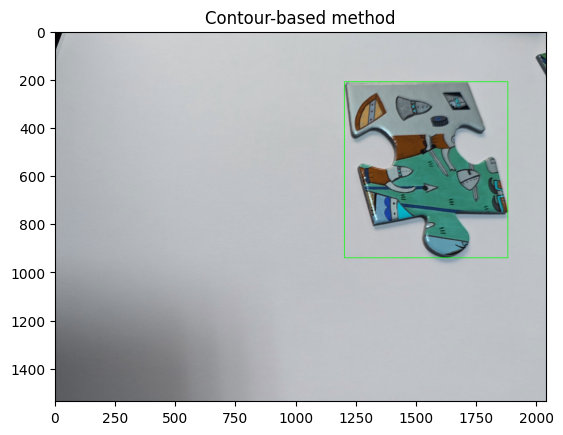

In [175]:
boxes = _contour_method(im1g)
filtered_boxes = _filter_boxes(boxes, 2*10**5, 10**7)
plot_box_im(im1, filtered_boxes, 'Contour-based method')

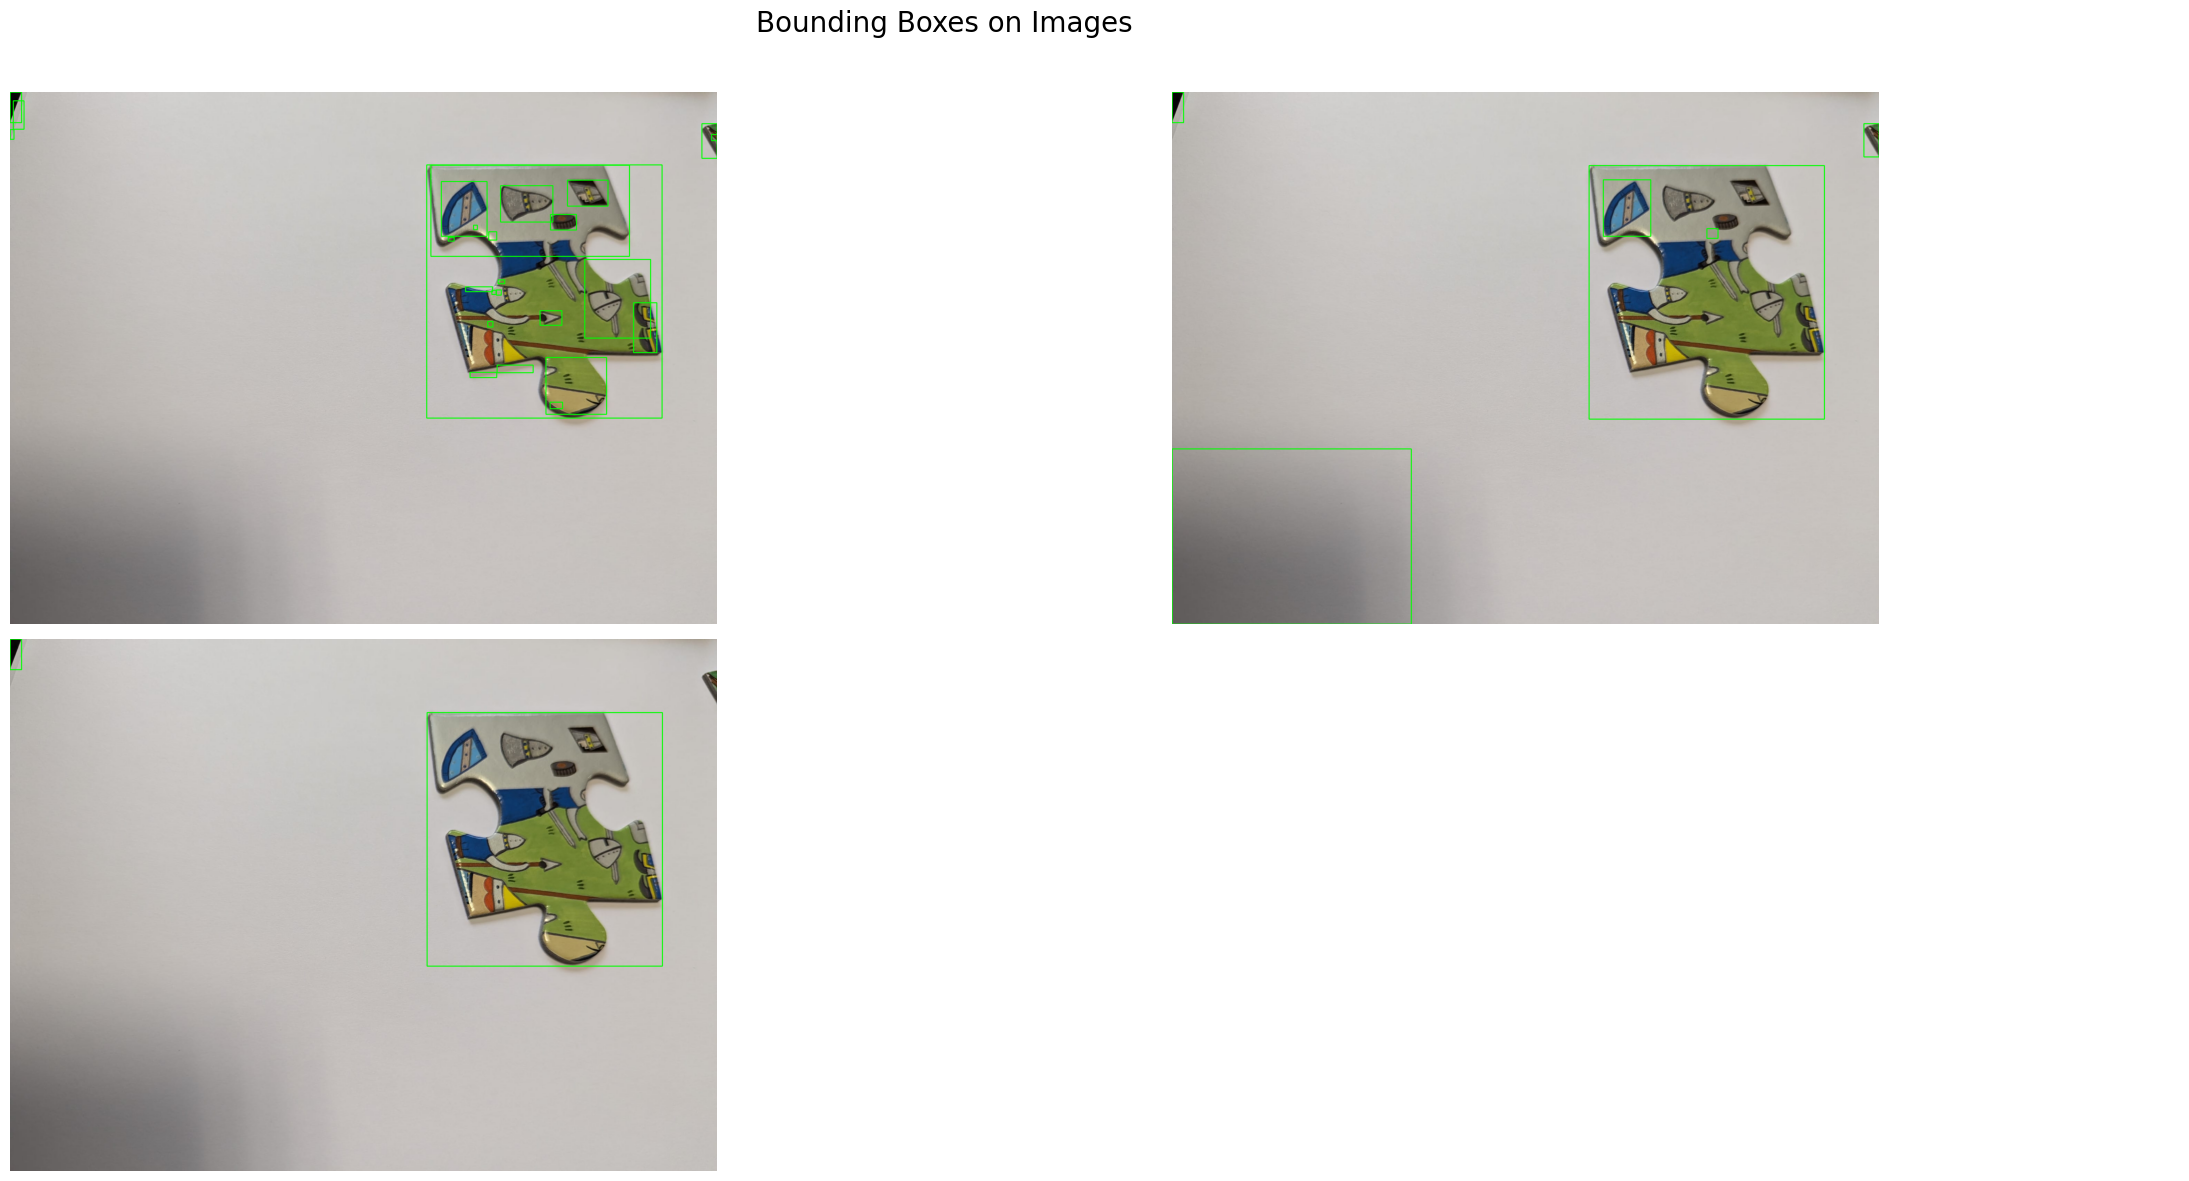

In [176]:
boxes_cc = _connected_components_method(im1g)
boxes_co=_contour_method(im1g)
boxes_match = compare_boxes(boxes_cc, boxes_co, 0.99)
L_boxes=[boxes_co,boxes_cc,boxes_match]
L_im=[im1,im1,im1]
plot_Lbox_Lim(L_boxes, L_im, title="Bounding Boxes on Images")


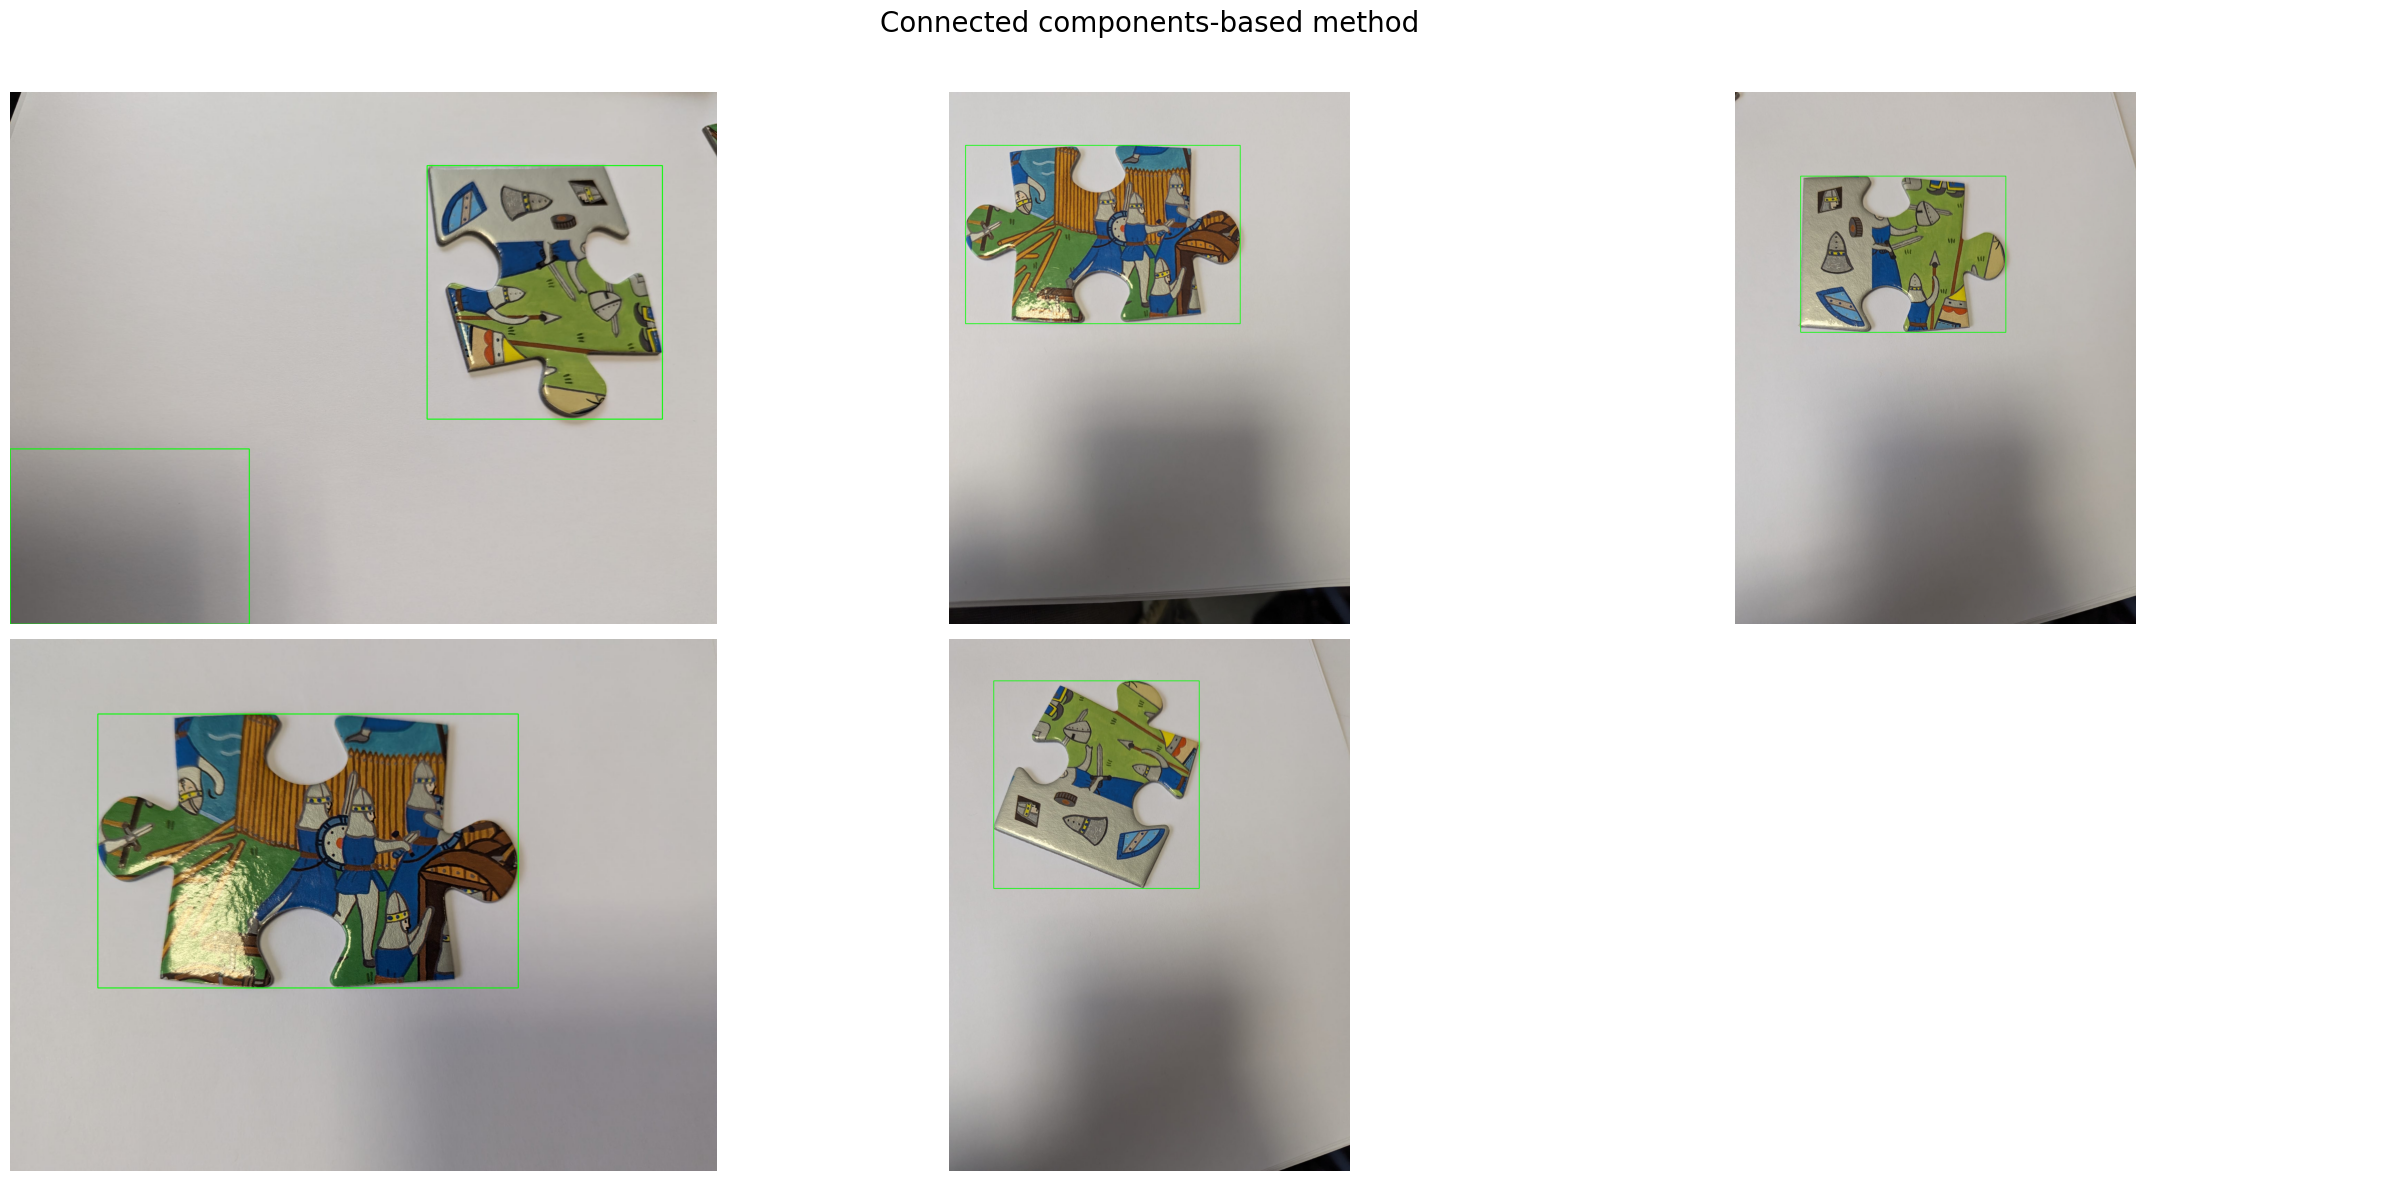

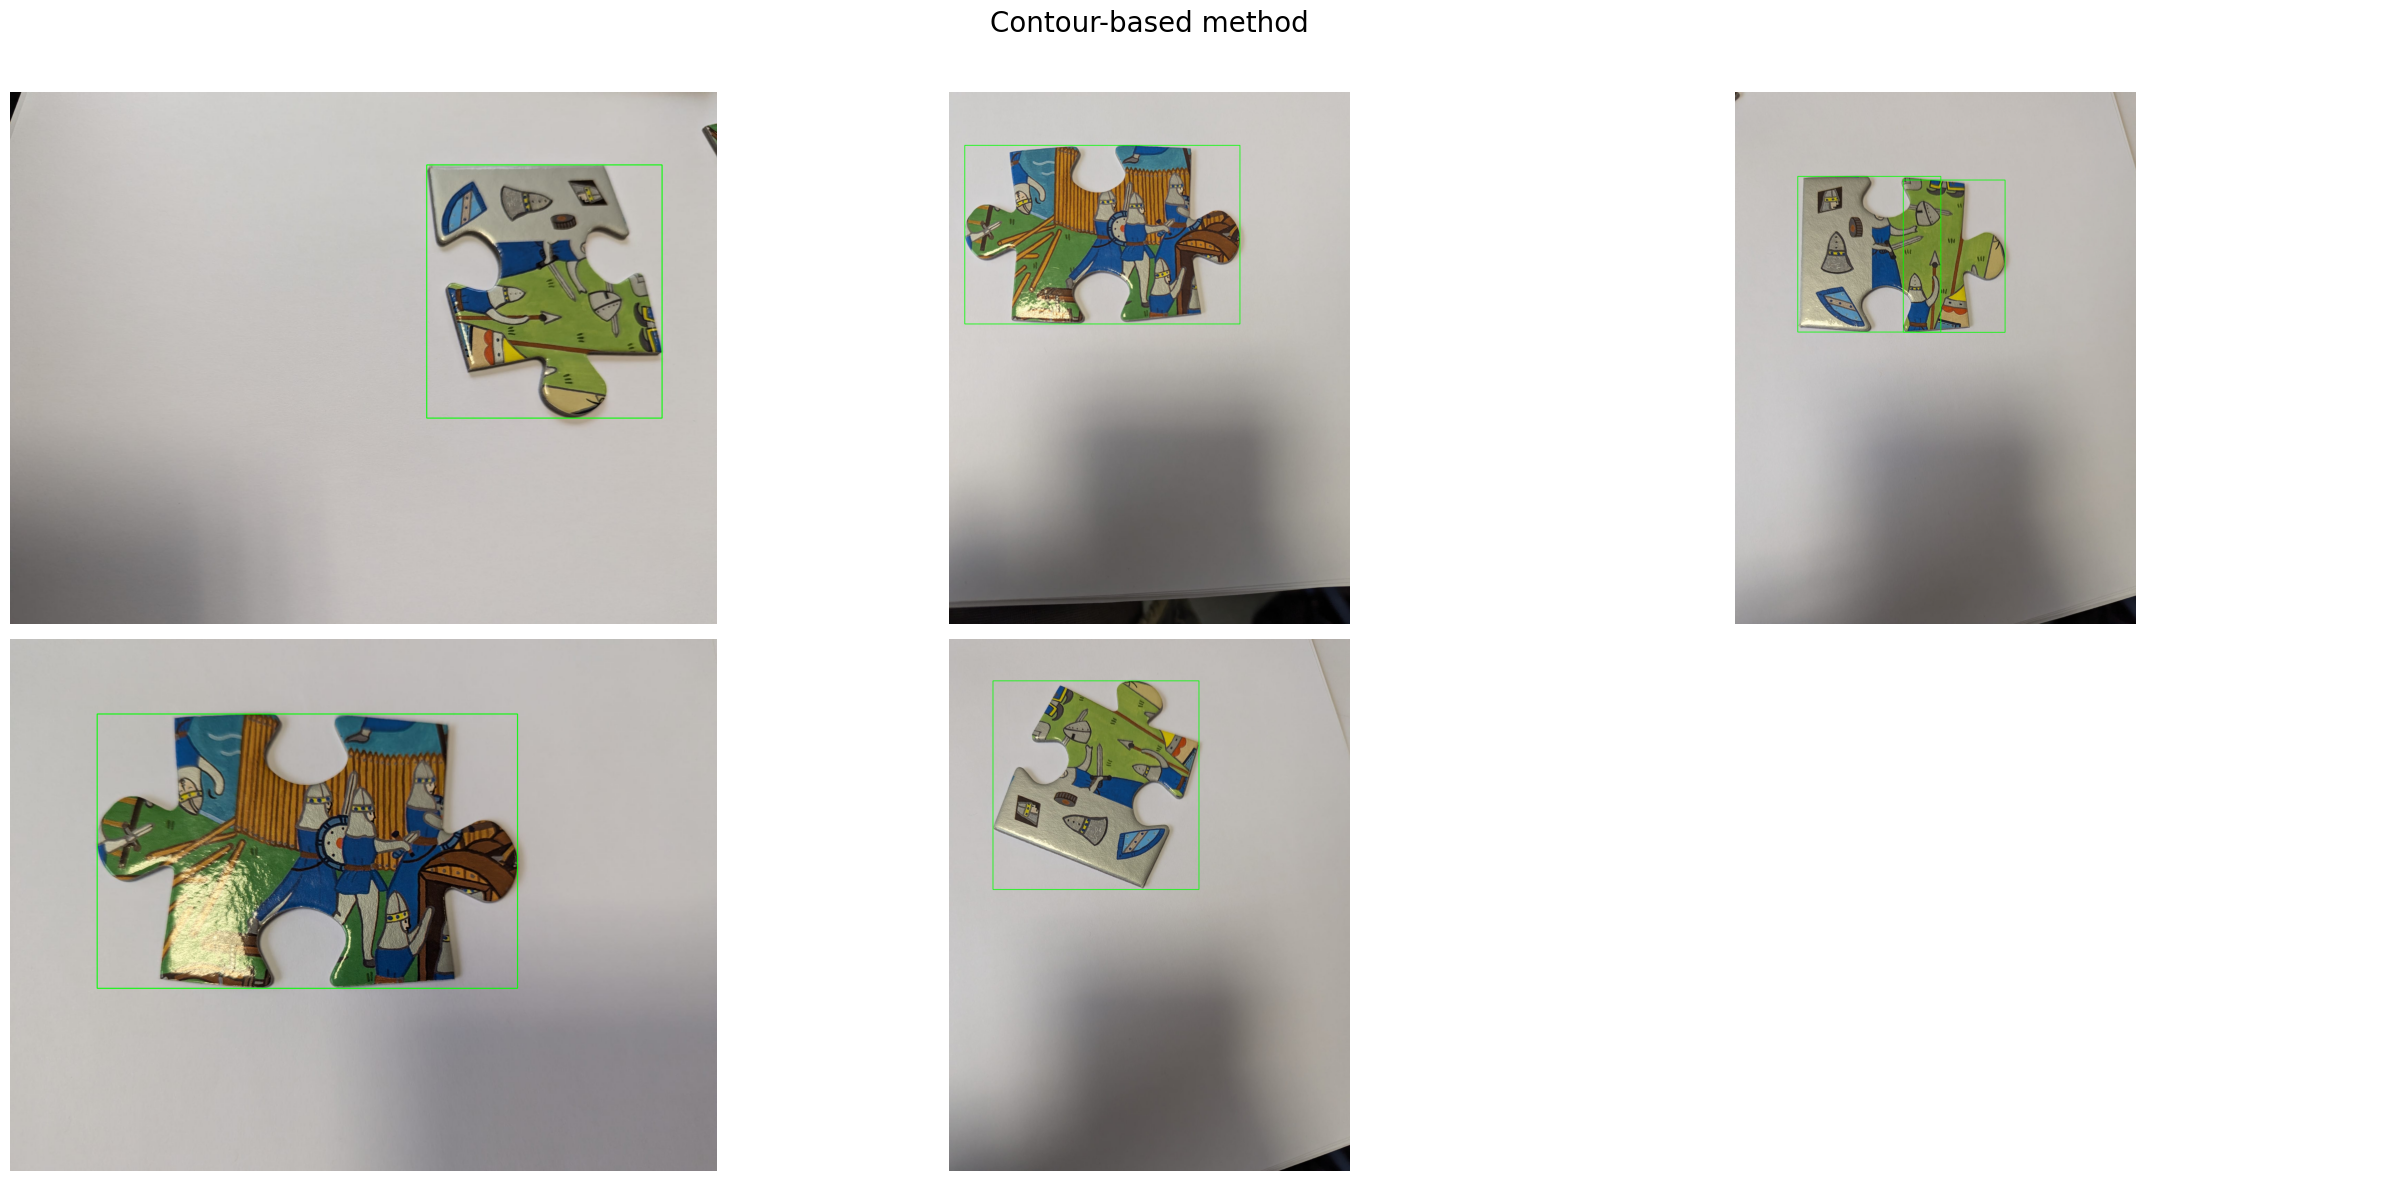

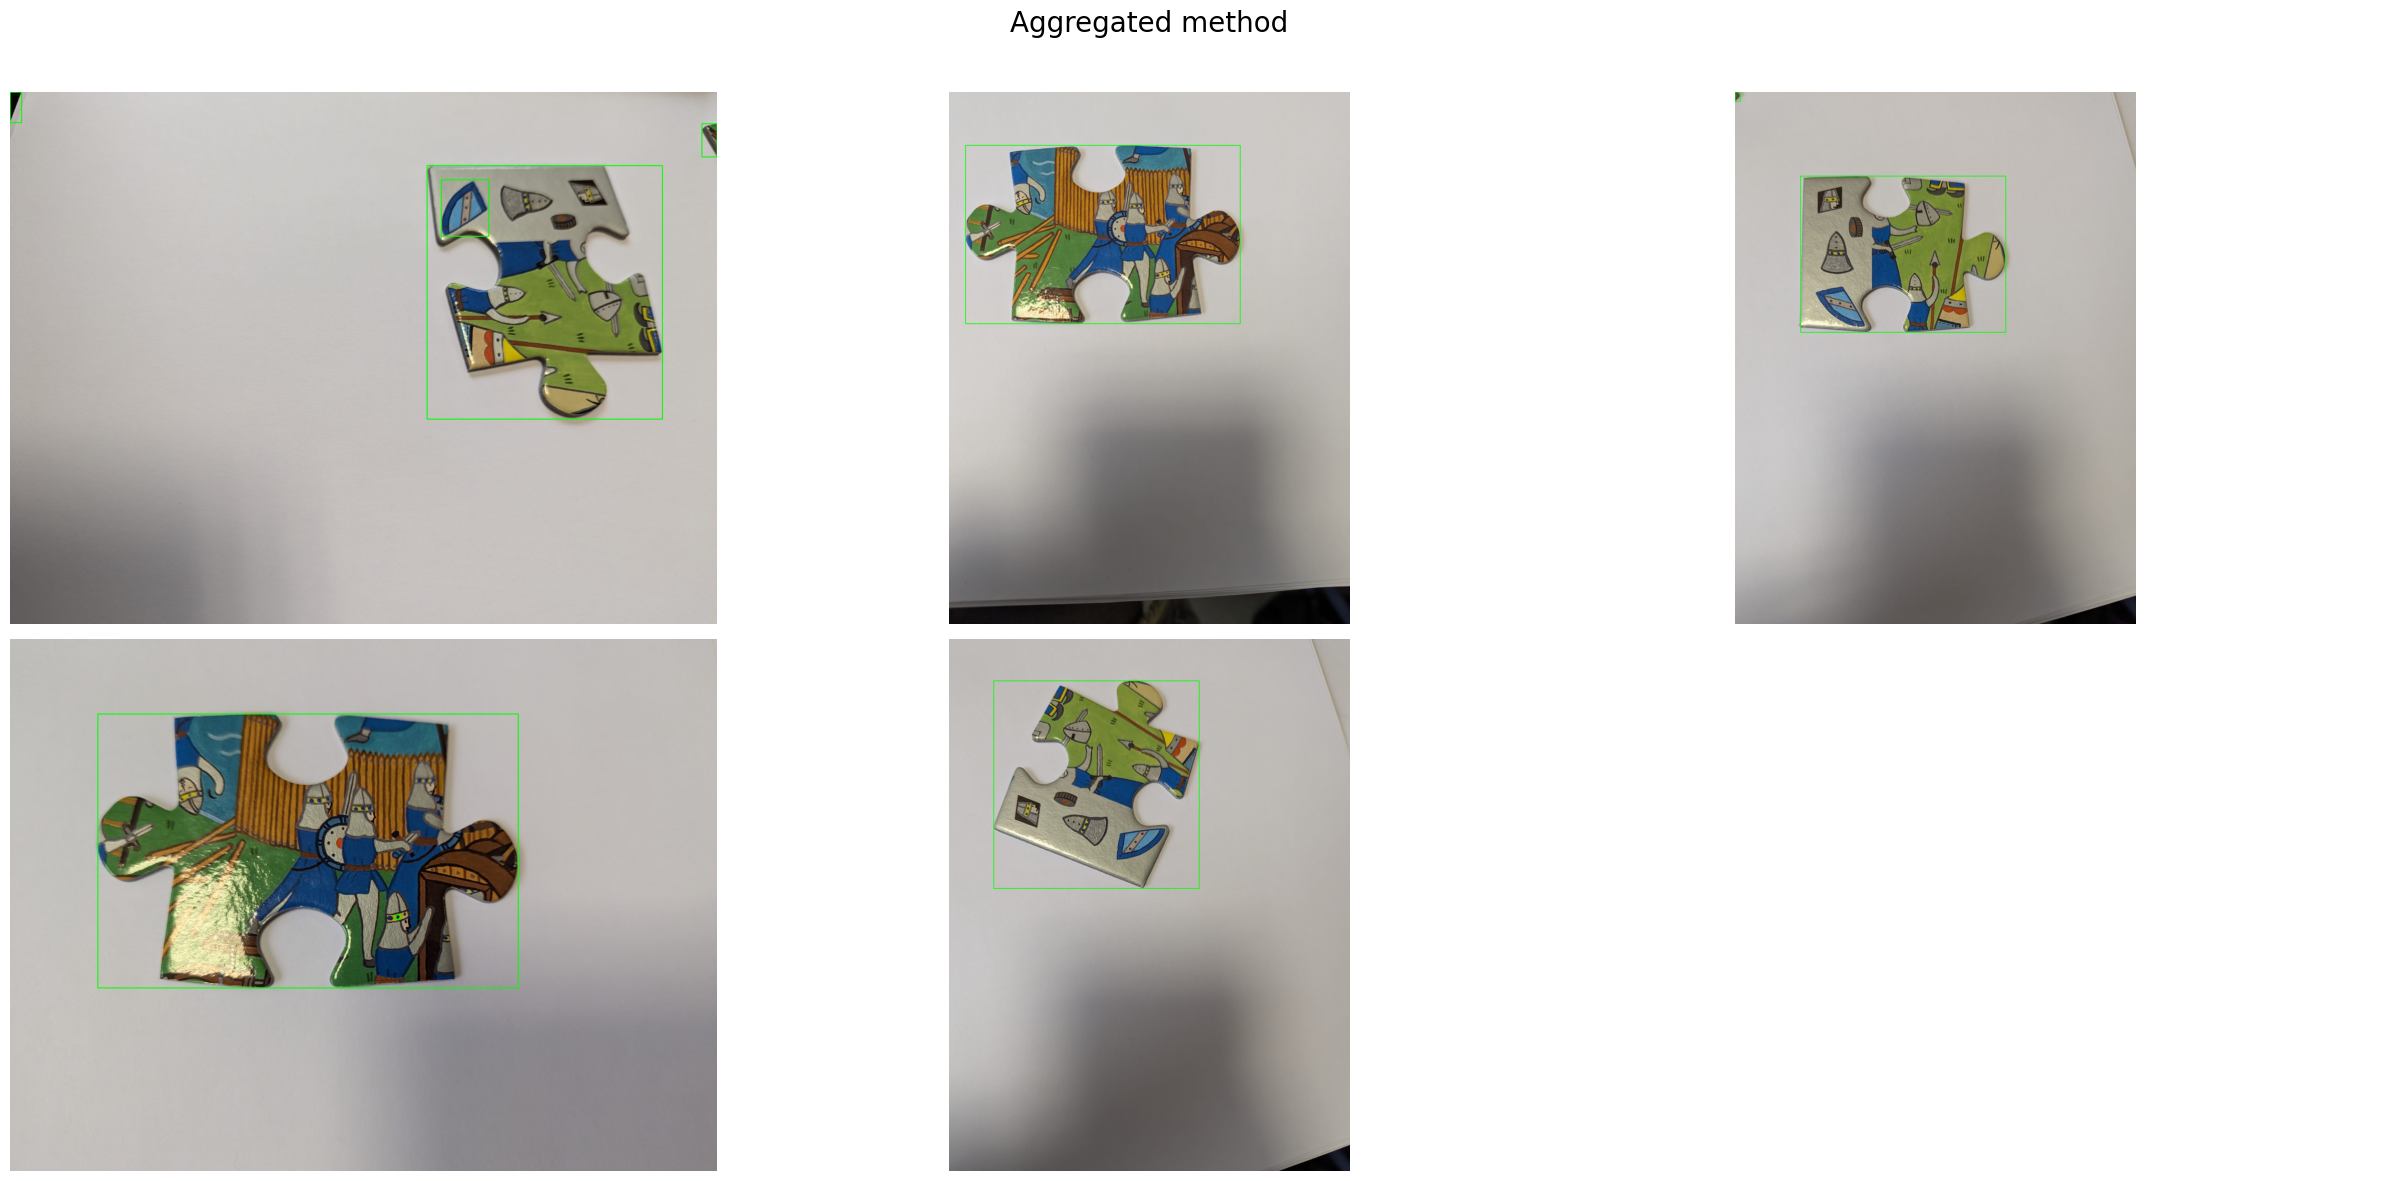

In [177]:
L_connected = []
L_contour = []
L_aggregated = []

for i in range(len(Limg)):
    L_connected.append(_connected_components_method(Limg[i]))
    L_contour.append(_contour_method(Limg[i]))
    L_connected[i] = _filter_boxes(L_connected[i], 2*10**5, 10**6)
    L_contour[i] = _filter_boxes(L_contour[i], 2*10**5, 10**7)
    L_aggregated.append(boxes_comparison(Limg[i]))

plot_Lbox_Lim(L_connected, Lim, 'Connected components-based method')
plot_Lbox_Lim(L_contour, Lim, 'Contour-based method')
plot_Lbox_Lim(L_aggregated, Lim, 'Aggregated method')